#Importing Libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# Loading the Heart Attack Dataset

In [21]:
df = pd.read_csv('balanced_heart_disease_mixed.csv')

column_names = {
    'age': 'Age',
    'sex': 'Sex',
    'chest pain type': 'ChestPainType',
    'resting bp s': 'RestingBP',
    'cholesterol': 'Cholesterol',
    'fasting blood sugar': 'FastingBS',
    'resting ecg': 'RestingECG',
    'max heart rate': 'MaxHeartRate',
    'exercise angina': 'ExerciseAngina',
    'oldpeak': 'STDepression',
    'ST slope': 'STSlope',
    'target': 'Target'
}

# Checking if columns need renaming

In [22]:
existing_columns = set(df.columns)
columns_to_rename = {old: new for old, new in column_names.items() if old in existing_columns}
if columns_to_rename:
    df.rename(columns=columns_to_rename, inplace=True)

# Displaying Data Information

In [23]:
print("Dataset Information:")
print(f"Number of samples: {len(df)}")
print(f"Target distribution: {df['Target'].value_counts(normalize=True).to_dict()}")

Dataset Information:
Number of samples: 8000
Target distribution: {1: 0.5, 0: 0.5}


In [24]:
# Filter dataset for hypertensive patients only (RestingBP >= 140)
df = df[df['RestingBP'] >= 140]

In [42]:
df.value_counts()
df.shape

(6137, 12)

# Define features and target

In [26]:
X = df.drop('Target', axis=1)
y = df['Target']
df.Target.head(10)

,Target
0,1
1,1
3,1
4,0
5,1
6,1
7,1
9,1
10,1
12,1


# Check for missing values in the dataset

In [27]:
print("Missing Values Analysis:")
print("=" * 40)
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing_Count': missing_summary.values,
    'Missing_Percentage': missing_percentage.values
})

print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("✓ No missing values found in the dataset")
else:
    print(f"Total missing values: {missing_df['Missing_Count'].sum()}")

print("\nDataset shape:", df.shape)
print("=" * 40)

Missing Values Analysis:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []
✓ No missing values found in the dataset

Dataset shape: (6137, 12)


### Prepare Features

In [28]:
if 'Sex' in X.columns:
    X['Sex'] = X['Sex'].astype(int)

# For chest pain type (1-4)
if 'ChestPainType' in X.columns:
    X = pd.get_dummies(X, columns=['ChestPainType'], prefix='ChestPain')

# For resting ECG (0,1,2)
if 'RestingECG' in X.columns:
    X = pd.get_dummies(X, columns=['RestingECG'], prefix='ECG')

# For ST slope (0,1,2)
if 'STSlope' in X.columns:
    X = pd.get_dummies(X, columns=['STSlope'], prefix='STSlope')

# 2. Create interaction features
X['Age_MaxHR'] = X['Age'] * X['MaxHeartRate'] / 100  # Normalized interaction
X['BP_Chol'] = X['RestingBP'] * X['Cholesterol'] / 1000  # Scale for numerical stability

# Create features for cardiovascular fitness
X['MaxHR_by_Age'] = X['MaxHeartRate'] / X['Age']  # Heart rate relative to age

# Additional interaction for angina patients
if 'ExerciseAngina' in X.columns:
    X['Angina_STDepression'] = X['ExerciseAngina'] * X['STDepression']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

#Normalization and Standardization
numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train_resampled_scaled = X_train_resampled.copy()
X_train_resampled_scaled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Add back any non-numeric columns
for col in X_train_resampled.columns:
    if col not in numerical_features:
        X_train_resampled_scaled[col] = X_train_resampled[col]
        X_test_scaled[col] = X_test[col]

feature_list = X_train.columns


In [29]:
X.head(20)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHeartRate,ExerciseAngina,STDepression,ChestPain_1,ChestPain_2,...,ECG_1,ECG_2,STSlope_0,STSlope_1,STSlope_2,STSlope_3,Age_MaxHR,BP_Chol,MaxHR_by_Age,Angina_STDepression
0,60,1,144,228,0,116,1,0.9,False,False,...,False,False,False,False,True,False,69.60,32.832,1.933333,0.9
1,42,0,148,165,1,100,0,0.4,False,False,...,False,True,False,False,True,False,42.00,24.420,2.380952,0.0
3,59,1,146,100,0,112,0,0.0,False,True,...,True,False,False,True,False,False,66.08,14.600,1.898305,0.0
4,62,1,140,201,0,93,0,1.3,False,True,...,False,True,False,False,True,False,57.66,28.140,1.500000,0.0
5,51,1,140,255,0,122,1,0.2,False,True,...,False,True,False,True,False,False,62.22,35.700,2.392157,0.2
6,40,0,140,100,1,147,0,1.0,False,True,...,False,True,False,True,False,False,58.80,14.000,3.675000,0.0
7,47,1,150,147,0,131,0,0.0,False,False,...,False,False,False,False,True,False,61.57,22.050,2.787234,0.0
9,38,1,174,154,0,149,0,0.6,False,False,...,False,False,False,True,False,False,56.62,26.796,3.921053,0.0
10,64,1,179,285,0,152,0,1.4,False,True,...,False,False,False,False,True,False,97.28,51.015,2.375000,0.0
12,46,1,140,227,0,154,0,1.0,False,True,...,True,False,False,False,True,False,70.84,31.780,3.347826,0.0


### Encode Labels

In [30]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

cv_scores = cross_val_score(
    xgb_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the model
xgb_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)


F1 scores: [0.76470588 0.76168757 0.77085781 0.79123414 0.75550406]
Mean F1: 0.7688 (+/- 0.0245)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Train a Mighty Random Forest

In [31]:
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Print comprehensive metrics
print("\nFinal XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Final XGBoost Model Performance:
Accuracy: 0.8091
Precision: 0.8565
Recall: 0.7471
F1-Score: 0.7981
AUC-ROC: 0.8954
Confusion Matrix:
[[663  97]
 [196 579]]


In [45]:
# Feature importance analysis
importance_df = pd.DataFrame({
    'Feature': X_train_resampled_scaled.columns,
    'Importance': xgb_model.feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nTop 15 Most Important Features:")
print(importance_df.head(15))

# Let's also try a Random Forest with optimal parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    rf_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1'
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

rf_model.fit(X_train_resampled_scaled, y_train_resampled)





Top 15 Most Important Features:
           Feature  Importance
17       STSlope_2    0.057084
4        FastingBS    0.056118
10     ChestPain_3    0.055363
19       Age_MaxHR    0.054465
21    MaxHR_by_Age    0.052868
20         BP_Chol    0.052202
18       STSlope_3    0.051412
8      ChestPain_1    0.051344
6   ExerciseAngina    0.047633
11     ChestPain_4    0.047263
1              Sex    0.045070
5     MaxHeartRate    0.044553
3      Cholesterol    0.044477
7     STDepression    0.043237
14           ECG_2    0.040465
Cross-validation F1 scores: [0.89189189 0.89777778 0.90617849 0.90660592 0.89841986]
Mean F1 score: 0.9002
Standard deviation: 0.0056


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=2, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [46]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"Sensitivity (Recall): {recall_score(y_test, y_pred_rf):.4f}")
print(f"Specificity: {recall_score(y_test, y_pred_rf, pos_label=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nTop 15 Most Important Features:")
print(importance_df.head(15))



Optimized Random Forest Performance:
Accuracy: 0.9336
Precision: 0.9693
Recall: 0.8968
Sensitivity (Recall): 0.8968
Specificity: 0.9711
F1-Score: 0.9316
AUC-ROC: 0.9838
Confusion Matrix:
[[738  22]
 [ 80 695]]

Top 15 Most Important Features:
           Feature  Importance
17       STSlope_2    0.057084
4        FastingBS    0.056118
10     ChestPain_3    0.055363
19       Age_MaxHR    0.054465
21    MaxHR_by_Age    0.052868
20         BP_Chol    0.052202
18       STSlope_3    0.051412
8      ChestPain_1    0.051344
6   ExerciseAngina    0.047633
11     ChestPain_4    0.047263
1              Sex    0.045070
5     MaxHeartRate    0.044553
3      Cholesterol    0.044477
7     STDepression    0.043237
14           ECG_2    0.040465


In [34]:
from sklearn.svm import SVC


svm_model = SVC(probability=True, random_state=42)

cv_scores = cross_val_score(
    svm_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1'
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# Fit the model to the scaled training data
svm_model.fit(X_train_resampled_scaled, y_train_resampled)

# Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nSVM Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Cross-validation F1 scores: [0.65654206 0.64576074 0.6464891  0.62650602 0.65700483]
Mean F1 score: 0.6465
Standard deviation: 0.0111

SVM Model Performance:
Accuracy: 0.7003
Precision: 0.7361
Recall: 0.6335
F1-Score: 0.6810
AUC-ROC: 0.7664
Confusion Matrix:
[[584 176]
 [284 491]]


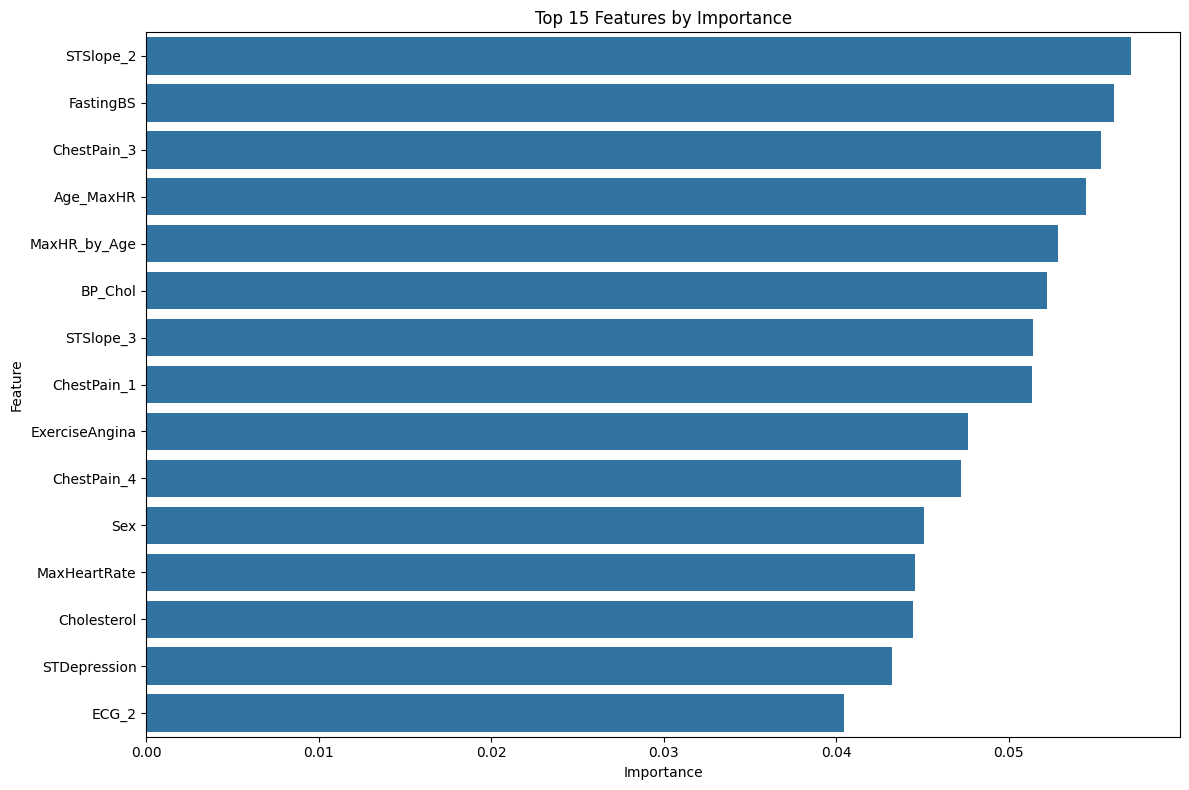

In [35]:
# Create visualization for feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
import joblib

def predict_heart_attack_hypertensive(patient_data, xgb_model=None, rf_model=None, svm_model=None, scaler=None, feature_list=None, training_numerical_features=None):
    """
    Predicts heart attack risk for hypertensive patients using all three models
    (XGBoost, Random Forest, SVM) and provides ensemble results.

    Parameters:
    -----------
    patient_data : dict
        Dictionary containing patient information with keys:
        - 'Age': int (patient age)
        - 'Sex': int (0=female, 1=male)
        - 'ChestPainType': int (1-4, chest pain type)
        - 'RestingBP': int (resting blood pressure, should be >= 140 for hypertensive)
        - 'Cholesterol': int (cholesterol level)
        - 'FastingBS': int (fasting blood sugar, 0 or 1)
        - 'RestingECG': int (resting ECG, 0-2)
        - 'MaxHeartRate': int (maximum heart rate)
        - 'ExerciseAngina': int (exercise-induced angina, 0 or 1)
        - 'STDepression': float (ST depression)
        - 'STSlope': int (ST slope, 0-2)

    xgb_model : XGBClassifier object
        Trained XGBoost model

    rf_model : RandomForestClassifier object
        Trained Random Forest model

    svm_model : SVC object
        Trained SVM model

    scaler : StandardScaler object
        Fitted scaler from training (if None, function returns unscaled features)

    feature_list : list
        List of feature names used during training.

    training_numerical_features : list
        A list of numerical feature names from the training data *before* one-hot encoding.


    Returns:
    --------
    dict : Prediction results from all models and ensemble prediction
    """

    # Validate that patient is hypertensive
    if patient_data['RestingBP'] < 140:
        raise ValueError("This function is designed for hypertensive patients (RestingBP >= 140)")

    # Create DataFrame from patient data
    df = pd.DataFrame([patient_data])

    # Apply the same column renaming as in training
    column_names = {
        'age': 'Age',
        'sex': 'Sex',
        'chest pain type': 'ChestPainType',
        'resting bp s': 'RestingBP',
        'cholesterol': 'Cholesterol',
        'fasting blood sugar': 'FastingBS',
        'resting ecg': 'RestingECG',
        'max heart rate': 'MaxHeartRate',
        'exercise angina': 'ExerciseAngina',
        'oldpeak': 'STDepression',
        'ST slope': 'STSlope',
        'target': 'Target'
    }

    existing_columns = set(df.columns)
    columns_to_rename = {old: new for old, new in column_names.items() if old in existing_columns}
    if columns_to_rename:
        df.rename(columns=columns_to_rename, inplace=True)

    # Remove target column if it exists (for prediction, we don't have target)
    if 'Target' in df.columns:
        df = df.drop('Target', axis=1)

    X = df.copy()

    # Apply the same preprocessing as in training (matching cell 34d7f5b3)

    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].astype(int)

    # One-hot encode categorical variables (same as training)
    if 'ChestPainType' in X.columns:
        X = pd.get_dummies(X, columns=['ChestPainType'], prefix='ChestPain')

    if 'RestingECG' in X.columns:
        X = pd.get_dummies(X, columns=['RestingECG'], prefix='ECG')

    if 'STSlope' in X.columns:
        X = pd.get_dummies(X, columns=['STSlope'], prefix='STSlope')

    # Create the same interaction features as in training
    X['Age_MaxHR'] = X['Age'] * X['MaxHeartRate'] / 100  # Normalized interaction
    X['BP_Chol'] = X['RestingBP'] * X['Cholesterol'] / 1000  # Scale for numerical stability
    X['MaxHR_by_Age'] = X['MaxHeartRate'] / X['Age']  # Heart rate relative to age

    # Additional interaction for angina patients
    if 'ExerciseAngina' in X.columns:
        X['Angina_STDepression'] = X['ExerciseAngina'] * X['STDepression']

    # Reindex to ensure all columns from training are present, fill missing with 0
    if feature_list is not None:
        X = X.reindex(columns=feature_list, fill_value=0)


    # If scaler is provided, apply scaling to numerical features
    if scaler is not None and training_numerical_features is not None:
        X_scaled = X.copy()
        # Ensure the order and presence of numerical features matches the scaler's expected input
        # Filter X to only include the numerical features from training, then scale
        X_scaled[training_numerical_features] = scaler.transform(X[training_numerical_features])

        # Add back any non-numerical (dummy) columns
        non_numerical_features = [col for col in X.columns if col not in training_numerical_features]
        X_scaled[non_numerical_features] = X[non_numerical_features]

        X_processed = X_scaled
    else:
        X_processed = X

    # Check if any models are provided
    models_provided = [xgb_model, rf_model, svm_model]
    if all(model is None for model in models_provided):
        return {
            'processed_features': X_processed,
            'feature_names': list(X_processed.columns),
            'message': 'Features processed successfully. Provide trained models for predictions.'
        }

    # Initialize results dictionary
    results = {
        'individual_predictions': {},
        'ensemble_prediction': {},
        'processed_features': X_processed
    }

    predictions_proba = []
    predictions_binary = []
    model_names = []

    # Make predictions with each available model
    try:
        # XGBoost predictions
        if xgb_model is not None:
            xgb_proba = xgb_model.predict_proba(X_processed)[0, 1]
            xgb_binary = xgb_model.predict(X_processed)[0]

            results['individual_predictions']['XGBoost'] = {
                'probability': round(xgb_proba, 4),
                'binary_prediction': int(xgb_binary),
                'risk_level': 'High Risk' if xgb_binary == 1 else 'Low Risk',
                'confidence': round(max(xgb_proba, 1 - xgb_proba), 4)
            }

            predictions_proba.append(xgb_proba)
            predictions_binary.append(xgb_binary)
            model_names.append('XGBoost')

        # Random Forest predictions
        if rf_model is not None:
            rf_proba = rf_model.predict_proba(X_processed)[0, 1]
            rf_binary = rf_model.predict(X_processed)[0]

            results['individual_predictions']['RandomForest'] = {
                'probability': round(rf_proba, 4),
                'binary_prediction': int(rf_binary),
                'risk_level': 'High Risk' if rf_binary == 1 else 'Low Risk',
                'confidence': round(max(rf_proba, 1 - rf_proba), 4)
            }

            predictions_proba.append(rf_proba)
            predictions_binary.append(rf_binary)
            model_names.append('RandomForest')

        # SVM predictions
        if svm_model is not None:
            svm_proba = svm_model.predict_proba(X_processed)[0, 1]
            svm_binary = svm_model.predict(X_processed)[0]

            results['individual_predictions']['SVM'] = {
                'probability': round(svm_proba, 4),
                'binary_prediction': int(svm_binary),
                'risk_level': 'High Risk' if svm_binary == 1 else 'Low Risk',
                'confidence': round(max(svm_proba, 1 - svm_proba), 4)
            }

            predictions_proba.append(svm_proba)
            predictions_binary.append(svm_binary)
            model_names.append('SVM')

        # Ensemble predictions
        if len(predictions_proba) > 1:
            # Average probability ensemble
            ensemble_proba = np.mean(predictions_proba)
            ensemble_binary = 1 if ensemble_proba >= 0.5 else 0

            # Voting ensemble (majority vote)
            voting_prediction = 1 if sum(predictions_binary) >= len(predictions_binary) / 2 else 0

            # Agreement score (how many models agree)
            agreement_score = max(sum(predictions_binary), len(predictions_binary) - sum(predictions_binary)) / len(predictions_binary)

            results['ensemble_prediction'] = {
                'average_probability': round(ensemble_proba, 4),
                'average_based_prediction': int(ensemble_binary),
                'voting_based_prediction': int(voting_prediction),
                'risk_level_average': 'High Risk' if ensemble_binary == 1 else 'Low Risk',
                'risk_level_voting': 'High Risk' if voting_prediction == 1 else 'Low Risk',
                'model_agreement': round(agreement_score, 4),
                'models_used': model_names,
                'confidence': round(max(ensemble_proba, 1 - ensemble_proba), 4)
            }
        else:
            # Only one model available, use its prediction as ensemble
            results['ensemble_prediction'] = {
                'probability': predictions_proba[0],
                'binary_prediction': predictions_binary[0],
                'risk_level': 'High Risk' if predictions_binary[0] == 1 else 'Low Risk',
                'models_used': model_names,
                'note': 'Only one model available - no ensemble calculation'
            }

        return results

    except Exception as e:
        return {
            'error': f"Prediction failed: {str(e)}",
            'processed_features': X_processed,
            'models_attempted': model_names
        }

# Example patient data (hypertensive patient)
patient_example = {
    'Age': 80,
    'Sex': 1,  # Male
    'ChestPainType': 1,  # Atypical angina
    'RestingBP': 140,  # Hypertensive (>= 140)
    'Cholesterol': 270,
    'FastingBS': 0,  # Elevated fasting blood sugar
    'RestingECG': 1,  # ST-T wave abnormality
    'MaxHeartRate': 170,
    'ExerciseAngina': 1,  # Exercise-induced angina
    'STDepression': 2,
    'STSlope': 1  # Flat slope
}

# Get the list of numerical features from the training data *before* one-hot encoding
training_numerical_features = X_train_resampled.select_dtypes(include=np.number).columns.tolist()


# Example usage function
def example_usage():
    """
    Example of how to use the prediction function with all three models
    """

    # Test with feature processing only
    result = predict_heart_attack_hypertensive(patient_example, xgb_model=None, rf_model=None, svm_model=None, scaler=None, feature_list=X_train_resampled_scaled.columns, training_numerical_features=training_numerical_features)
    print("Processed features shape:", result['processed_features'].shape)
    print("Feature names:", result['processed_features'].columns.tolist()[:10], "...")  # Show first 10 features

    return result

def print_prediction_results(results):
    """
    Helper function to nicely print prediction results from all models
    """
    if 'error' in results:
        print(f"Error: {results['error']}")
        return

    print("="*60)
    print("HEART ATTACK RISK PREDICTION FOR HYPERTENSIVE PATIENT")
    print("="*60)

    # Print individual model results
    if 'individual_predictions' in results:
        print("\n📊 INDIVIDUAL MODEL PREDICTIONS:")
        print("-" * 40)

        for model_name, pred in results['individual_predictions'].items():
            print(f"\n{model_name}:")
            print(f"  • Risk Level: {pred['risk_level']}")
            print(f"  • Probability: {pred['probability']:.1%}")
            print(f"  • Confidence: {pred['confidence']:.1%}")
            print(f"  • Binary: {pred['binary_prediction']}")

    # Print ensemble results
    if 'ensemble_prediction' in results:
        print(f"\n🎯 ENSEMBLE PREDICTION:")
        print("-" * 40)

        ensemble = results['ensemble_prediction']
        if 'average_probability' in ensemble:
            print(f"  • Final Risk Level (Average): {ensemble['risk_level_average']}")
            print(f"  • Final Risk Level (Voting): {ensemble['risk_level_voting']}")
            print(f"  • Average Probability: {ensemble['average_probability']:.1%}")
            print(f"  • Model Agreement: {ensemble['model_agreement']:.1%}")
            print(f"  • Models Used: {', '.join(ensemble['models_used'])}")
            print(f"  • Ensemble Confidence: {ensemble['confidence']:.1%}")
        else:
            print(f"  • Risk Level: {ensemble['risk_level']}")
            print(f"  • Probability: {ensemble['probability']:.1%}")
            print(f"  • Note: {ensemble.get('note', '')}")

    print("\n" + "="*60)

# Test the function with feature processing only (no models)
print("Testing Heart Attack Prediction Function...")
print("=" * 50)

# Test with feature processing only
example_result = example_usage()
print("\n" + "=" * 50)
print("FEATURE PROCESSING TEST COMPLETE")
print("=" * 50)

# Example of what the output would look like with trained models
print("\n" + "=" * 50)
print("EXAMPLE OUTPUT WITH TRAINED MODELS:")
print("=" * 50)
simulated_results = predict_heart_attack_hypertensive(patient_example, xgb_model=xgb_model, rf_model=rf_model, svm_model=svm_model, scaler=scaler, feature_list=X_train_resampled_scaled.columns, training_numerical_features=training_numerical_features)
print_prediction_results(simulated_results)

Testing Heart Attack Prediction Function...
Processed features shape: (1, 23)
Feature names: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHeartRate', 'ExerciseAngina', 'STDepression', 'ChestPain_1', 'ChestPain_2'] ...

FEATURE PROCESSING TEST COMPLETE

EXAMPLE OUTPUT WITH TRAINED MODELS:
HEART ATTACK RISK PREDICTION FOR HYPERTENSIVE PATIENT

📊 INDIVIDUAL MODEL PREDICTIONS:
----------------------------------------

XGBoost:
  • Risk Level: High Risk
  • Probability: 71.2%
  • Confidence: 71.2%
  • Binary: 1

RandomForest:
  • Risk Level: High Risk
  • Probability: 67.4%
  • Confidence: 67.4%
  • Binary: 1

SVM:
  • Risk Level: High Risk
  • Probability: 69.8%
  • Confidence: 69.8%
  • Binary: 1

🎯 ENSEMBLE PREDICTION:
----------------------------------------
  • Final Risk Level (Average): High Risk
  • Final Risk Level (Voting): High Risk
  • Average Probability: 69.5%
  • Model Agreement: 100.0%
  • Models Used: XGBoost, RandomForest, SVM
  • Ensemble Confidence: 69.5%
